In [72]:
# import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from sklearn import preprocessing, linear_model, model_selection
from sklearn.tree import DecisionTreeRegressor as DTR
import statsmodels.api as sm
from itertools import product
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import make_scorer 


%matplotlib inline
#%pylab inline

Класс моделей ARIMA недостаточно богат для наших данных: с их помощью, например, никак нельзя учесть взаимосвязи между рядами. Это можно сделать с помощью векторной авторегрессии VARIMA, но её питоновская реализация не позволяет использовать регрессионные признаки. Кроме того, авторегрессионный подход не позволяет учитывать, например, взаимодействия между сезонными компонентами. Вы могли заметить, что форма суточных сезонных профилей в будни и выходные немного разная; явно моделировать этот эффект с помощью ARIMA не получится.

Нам нужна более сложная модель. Давайте займёмся сведением задачи массового прогнозирования рядов к регрессионной постановке! Вам понадобится много признаков. Некоторые из них у вас уже есть — это:
<ol>
<li>идентификатор географической зоны
<li>дата и время
<li>количество поездок в периоды, предшествующие прогнозируемому
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA
<li>Кроме того, не спешите выбрасывать построенный вами на прошлой неделе прогнозы — из них может получиться хороший признак для регрессии!
</ol>



Вы можете попробовать разные регрессионный модели, но хорошие результаты, скорее всего, дадут такие, которые будут позволять признакам взаимодействовать друг с другом.

Поскольку прогноз нужен на 6 часов вперёд, проще всего будет построить 6 независимых регрессионных моделей — одна для прогнозирования y^T+1|T, другая для y^T+2|T и т.д.

<ol>Чтобы сдать задание, выполните следующую последовательность действий.
<li>Для каждой из шести задач прогнозирования y^T+i|T,i=1,…,6 сформируйте выборки. Откликом будет yT+i при всевозможных значениях T, а признаки можно использовать следующие:
<ul>
<li>идентификатор географической зоны — категориальный
<li>год, месяц, день месяца, день недели, час — эти признаки можно пробовать брать и категориальными, и непрерывными, можно даже и так, и так (done)
<li>синусы, косинусы и тренды, которые вы использовали внутри регрессионной компоненты ARIMA (done)
<li>сами значения прогнозов ARIMA y^T+i|TARIMA
<li>количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li>количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
</ul>
Будьте внимательны при создании признаков — все факторы должны быть рассчитаны без использования информации из будущего: при прогнозировании y^T+i|T,i=1,…,6 вы можете учитывать только значения y до момента времени T включительно.


<li>Выбранными моделями постройте для каждой географической зоны и каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 прогнозы на 6 часов вперёд; посчитайте в ноутбуке ошибку прогноза по следующему функционалу:
Qmay=1R∗739∗6∑r=1R∑T=2016.04.3023:002016.05.3117:00∑i=16y^T|T+ir−yT+ir.
Убедитесь, что ошибка полученных прогнозов, рассчитанная согласно функционалу Q, определённому на прошлой неделе, уменьшилась по сравнению с той, которую вы получили методом индивидуального применения моделей ARIMA. Если этого не произошло, попробуйте улучшить ваши модели.

<li>Итоговыми моделями постройте прогнозы для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 и запишите все результаты в один файл в формате geoID, histEndDay, histEndHour, step, y. Здесь geoID — идентификатор зоны, histEndDay — день конца истории в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

<li>Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

<li>Загрузите ноутбук в форму.

Подгружаем данные

In [2]:
# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# времянные ряды для этих регионов
df = pd.read_pickle('../loadData/crowdRegs3.pcl')
regNames = regsDf.regId.values.astype('str')
df.columns = regNames

Наверное, оптимальный способ - пройтись по всем регионам, сформировать требуемую выборку, а потом - состыковать. 
Вероятно, в процессе работы получится векторизовать это действие.
Пожалуй, имеет смысл сначала для всего фрейма добавить общие для всех колонок признаки (тренд, гармоники, даты, дни недели)

In [3]:
def processDataFrame(inpDf, Kw = 7, Ka = 2):
    """
    Обрабатываем сразу весь dateFrame и добавляем признаки, общие для всех рядов
    тренд, гармоники, категориальные перемнные
    для дат, дней недели, etc)

    Parameters:
    Kw number of weeks harmonics
    Ka number of annual harmonics
    """

    inpDf = inpDf.assign(linear = (inpDf.index - datetime.datetime(2014,1,1,0,0,0))/np.timedelta64(1, 'h'))
    
    # час — эти признаки можно пробовать брать и категориальными
    # и непрерывными, можно даже и так, и так

    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        inpDf['weekCos'+str(ind)]= np.cos(np.pi*inpDf.linear*ind/168)
        inpDf['weekSin'+str(ind)]= np.sin(np.pi*inpDf.linear*ind/168)
     
    for ind in range(1,Ka+1):
        inpDf['yearCos'+str(ind)]= np.cos(2*np.pi*inpDf.linear*ind/8766)        
        inpDf['yearSin'+str(ind)]= np.sin(2*np.pi*inpDf.linear*ind/8766)

    # добавляем числовое и категориальные свойства для дней недели
    inpDf = inpDf.assign(dayOfWeek = inpDf.index.dayofweek)
    lbDays = preprocessing.LabelBinarizer()
    lbDays.fit(list(np.arange(6)))
    DoW = pd.DataFrame(lbDays.transform(inpDf.index.dayofweek),columns = ['dayOfWeek_'+str(x) for x in np.arange(6)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(DoW,left_index=True,right_index=True)

    # добавляем dummy variables для месяца
    inpDf = inpDf.assign(month = inpDf.index.month)
    lbMonths = preprocessing.LabelBinarizer()
    lbMonths.fit(list(np.arange(12)))
    Months = pd.DataFrame(lbMonths.transform(inpDf.index.month),columns = ['month_'+str(x) for x in np.arange(1,13)],
                          index = inpDf.index)      
    inpDf = inpDf.merge(Months,left_index=True,right_index=True);

    # добавляем год (вещественный)
    inpDf = inpDf.assign(year = inpDf.index.year)

    # добавляем день месяца (вещественный)
    inpDf = inpDf.assign(day = inpDf.index.day)

    # добавляем час (вещественный и категориальный)
    inpDf = inpDf.assign(hour = inpDf.index.hour)
    lbHours = preprocessing.LabelBinarizer()
    lbHours.fit(list(np.arange(24)))
    Hours = pd.DataFrame(lbHours.transform(inpDf.index.hour),columns = ['hour_'+str(x) for x in np.arange(24)],
                       index = inpDf.index)      
    inpDf = inpDf.merge(Hours,left_index=True,right_index=True)
    
    return inpDf

Теперь делаем индивидуальную обработку для каждого региона
<ol>
<li> добавляем идентификатор географической зоны — категориальный
<li> количество поездок из рассматриваемого района в моменты времени yT,yT−1,…,yT−K (параметр K можно подбирать; попробуйте начать, например, с 6)
<li> количество поездок из рассматриваемого района в моменты времени yT−24,yT−48,…,yT−24∗Kd (параметр Kd можно подбирать; попробуйте начать, например, с 2)
<li>суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц 
2) 
</ol>

In [4]:
def processSeries(df,tReg,Kh = 6, Kp = 2):
    """
    Обработка одного данного ряда 
    parameters:
        df - начальный датафрейм, из которого выберем для обработки один ряд
        tReg - название ряда, который надо обработать
        Kh - количество отслеживаемых прошлых суточных лагов "назад"
        Kp - количество отслеживаемых прошлых периодических лагов (период 24 часа)

    """
 

    tDf = df.loc[:,tReg.split() + commonFeatures].rename(columns={tReg:'y'})

    tDf = tDf.assign(region = tReg)

    for timeLag in np.arange(1,Kh+1):
        name = 'hourLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag)

    for timeLag in np.arange(1,Kp+1):
        name = 'periodicLag_'+str(timeLag)
        tDf.loc[:,name] = tDf.y.shift(periods=timeLag*24)

    tDf.fillna(0,inplace=True)    

    # суммарное количество поездок из рассматриваемого района за предшествующие полдня, сутки, неделю, месяц
    tDf.loc[:,'sum12'] = tDf.y.rolling(window = 12, min_periods = 1).sum()
    tDf.loc[:,'sum24'] = tDf.y.rolling(window = 24, min_periods = 1).sum()
    tDf.loc[:,'sumWeek'] = tDf.y.rolling(window = 168, min_periods = 1).sum()
    tDf.loc[:,'sumMonth'] = tDf.y.rolling(window = 720, min_periods = 1).sum()
    
    #создаём шесть целевые переменных для каждого конца истории
    for targetVar in np.arange(1,7):
        name = 'y'+str(targetVar)
        tDf.loc[:,name] = tDf.y.shift(-targetVar)
    tDf.fillna(0,inplace=True)
    
    return tDf


In [5]:
def getTrips(X):
    model1 = bestModels.get('y1')
    model2 = bestModels.get('y2')
    model3 = bestModels.get('y3')
    model4 = bestModels.get('y4')
    model5 = bestModels.get('y5')
    model6 = bestModels.get('y6')
    pr1 = model1.predict(X)
    pr2 = model2.predict(X)
    pr3 = model3.predict(X)
    pr4 = model4.predict(X)
    pr5 = model5.predict(X)
    pr6 = model6.predict(X)
    pr1[pr1<0] = 0
    pr2[pr2<0] = 0
    pr3[pr3<0] = 0
    pr4[pr4<0] = 0
    pr5[pr5<0] = 0
    pr6[pr6<0] = 0
    
    return np.array([pr1, pr2, pr3, pr4, pr5, pr6])

In [6]:
def saveResults(rdf, fName):
    rnd = np.round

    f = open(fName,'w')
    f.writelines('id,y\n')

    for ind, row in rdf.iterrows():
        historyStart = row.date - datetime.timedelta(hours = 1)

        if historyStart > datetime.datetime(2016,6,30,17):
            continue

        s0 = str(row.region)+'_'+ str(datetime.datetime.strftime(historyStart, "%Y-%m-%d"))+ '_'+ str(historyStart.hour)

        s1 = s0 +'_1,'+str(rnd(row.get('y1'))) + '\n'
        f.writelines(s1)

        s2 = s0 +'_2,'+str(rnd(row.get('y2'))) + '\n'
        f.writelines(s2)

        s3 = s0 +'_3,'+str(rnd(row.get('y3'))) + '\n'
        f.writelines(s3)

        s4 = s0 +'_4,'+str(rnd(row.get('y4'))) + '\n'
        f.writelines(s4)

        s5 = s0 +'_5,'+str(rnd(row.get('y5'))) + '\n'
        f.writelines(s5)

        s6 = s0 +'_6,'+str(rnd(row.get('y6'))) + '\n'
        f.writelines(s6)

    f.close()    

In [7]:
# общая обработка данных
df2 = processDataFrame(df,Kw = 7, Ka = 2)
commonFeatures =  list(set(df2.columns)-set(df.columns.values))
# обработка отдельных рядов
df3 = pd.DataFrame()
for regName in regNames:
    df3 = pd.concat([df3, processSeries(df2,regName,Kh = 12, Kp = 4)])

#regDf = df3.get('region')
#df3 = pd.get_dummies(df3,'region')
#df3 = df3.assign(region = regDf)
df3.head()
#df3.to_pickle('df3.pcl')

,y,weekSin1,weekSin2,month,hour_19,hour_9,hour_8,year,hour_5,hour_4,...,sum12,sum24,sumWeek,sumMonth,y1,y2,y3,y4,y5,y6
2014-01-01 00:00:00,87,0.000000,0.000000,1,0,0,0,2014,0,0,...,87.0,87.0,87.0,87.0,92.0,108.0,77.0,47.0,22.0,10.0
2014-01-01 01:00:00,92,0.018699,0.037391,1,0,0,0,2014,0,0,...,179.0,179.0,179.0,179.0,108.0,77.0,47.0,22.0,10.0,18.0
2014-01-01 02:00:00,108,0.037391,0.074730,1,0,0,0,2014,0,0,...,287.0,287.0,287.0,287.0,77.0,47.0,22.0,10.0,18.0,19.0
2014-01-01 03:00:00,77,0.056070,0.111964,1,0,0,0,2014,0,0,...,364.0,364.0,364.0,364.0,47.0,22.0,10.0,18.0,19.0,28.0
2014-01-01 04:00:00,47,0.074730,0.149042,1,0,0,0,2014,0,1,...,411.0,411.0,411.0,411.0,22.0,10.0,18.0,19.0,28.0,37.0


In [ ]:
df3.to_pickle('df4.pcl')

In [ ]:
df3 = pd.read_pickle('df3.pcl')

In [8]:
startTrain = '2014-01-01 00:00:00'
endTrain   = '2016-04-30 23:00:00'

startValidation = '2016-05-01 00:00:00'
endValidation   = '2016-05-31 23:00:00'

startTest = '2016-06-01 00:00:00'
endTest   = '2016-06-30 23:00:00'

In [ ]:
df3 = df3.loc[startTrain:endTest,:]

In [9]:
#df3.reset_index(inplace=True)
df2

,y,weekSin1,weekSin2,month,hour_19,hour_9,hour_8,year,hour_5,hour_4,...,sum12,sum24,sumWeek,sumMonth,y1,y2,y3,y4,y5,y6
2014-01-01 00:00:00,87,0.000000,0.000000,1,0,0,0,2014,0,0,...,87.0,87.0,87.0,87.0,92.0,108.0,77.0,47.0,22.0,10.0
2014-01-01 01:00:00,92,0.018699,0.037391,1,0,0,0,2014,0,0,...,179.0,179.0,179.0,179.0,108.0,77.0,47.0,22.0,10.0,18.0
2014-01-01 02:00:00,108,0.037391,0.074730,1,0,0,0,2014,0,0,...,287.0,287.0,287.0,287.0,77.0,47.0,22.0,10.0,18.0,19.0
2014-01-01 03:00:00,77,0.056070,0.111964,1,0,0,0,2014,0,0,...,364.0,364.0,364.0,364.0,47.0,22.0,10.0,18.0,19.0,28.0
2014-01-01 04:00:00,47,0.074730,0.149042,1,0,0,0,2014,0,1,...,411.0,411.0,411.0,411.0,22.0,10.0,18.0,19.0,28.0,37.0


Разбейте каждую из шести выборок на три части:
<ul>
<li> Обучающая, на которой будут настраиваться параметры моделей — всё до апреля 2016
<li> Тестовая, на которой вы будете подбирать значения гиперпараметров — май 2016
<li> Итоговая, которая не будет использоваться при настройке моделей вообще — июнь 2016
</ul>

Теперь надо обучить регрессор на колонке y, откинув y1-y6

Для повторяемости стоит зафиксировать random_state 

Попробовать AdaBoost Regressor над деревьями.

In [16]:
targetList = ['y1','y2','y3','y4','y5','y6']
dropList = ['y1','y2','y3','y4','y5','y6','y']

Теперь надо обучить SARIMAX модель для каждого ряда и получить предсказания.
Для тестирования выбираем ряд 1075. Код SARIMAX модели берём из 4й недели.

In [11]:
tsGroups = df3.groupby('region')
dlCols = ['y','y1','y2','y3','y4','y5','y6']

In [77]:
df3.head()

,y,weekSin1,weekSin2,month,hour_19,hour_9,hour_8,year,hour_5,hour_4,...,sum12,sum24,sumWeek,sumMonth,y1,y2,y3,y4,y5,y6
2014-01-01 00:00:00,87,0.000000,0.000000,1,0,0,0,2014,0,0,...,87.0,87.0,87.0,87.0,92.0,108.0,77.0,47.0,22.0,10.0
2014-01-01 01:00:00,92,0.018699,0.037391,1,0,0,0,2014,0,0,...,179.0,179.0,179.0,179.0,108.0,77.0,47.0,22.0,10.0,18.0
2014-01-01 02:00:00,108,0.037391,0.074730,1,0,0,0,2014,0,0,...,287.0,287.0,287.0,287.0,77.0,47.0,22.0,10.0,18.0,19.0
2014-01-01 03:00:00,77,0.056070,0.111964,1,0,0,0,2014,0,0,...,364.0,364.0,364.0,364.0,47.0,22.0,10.0,18.0,19.0,28.0
2014-01-01 04:00:00,47,0.074730,0.149042,1,0,0,0,2014,0,1,...,411.0,411.0,411.0,411.0,22.0,10.0,18.0,19.0,28.0,37.0


In [17]:
df4 = pd.DataFrame()
for regId in tsGroups.groups.keys():
    print ' '
    print regId
    ts = tsGroups.get_group(regId)

    for target in targetList:
        linReg = linear_model.Ridge(alpha=0.1)
        linReg.fit(ts.loc[startTrain:endValidation,:].drop(dlCols,axis = 1),ts.loc[startTrain:endValidation,target])
        prediction = linReg.predict(ts.drop(dlCols,axis = 1))
        prediction[prediction<0] =0
        print target, ' ',MAE(prediction,ts.get(target))
        colName = target+'_reg'
        ts.loc[:,'regressor'] = prediction
    df4 = pd.concat([df4, ts])

 
1783
y1   35.183034219
y2   38.2383136321
y3   39.9871778817
y4   40.8147664123
y5   41.2841396943
y6   41.352207012
 
1076
y1   17.5368085011
y2   21.6893429289
y3   22.6864036001
y4   22.2852898302
y5   22.3981930094
y6   22.6020068799
 
1077
y1   15.2948564153
y2   18.1811557917
y3   18.2714623159
y4   17.8620396146
y5   16.4805043581
y6   15.3910886553
 
1075
y1   10.4979186021
y2   12.3835360056
y3   12.9918091012
y4   12.9731528576
y5   12.8559814731
y6   12.8141693497
 
1377
y1   4.22254210841
y2   5.32431393396
y3   5.8228895949
y4   5.79122228547
y5   5.67994786451
y6   5.6630788037
 
1376
y1   5.25528075449
y2   6.73074575269
y3   7.46225875773
y4   7.45778325145
y5   7.12968102201
y6   7.08765122975
 
1378
y1   3.59728009314
y2   4.22426684673
y3   4.44488708228
y4   4.4522120047
y5   4.38346754634
y6   4.43123985617
 
2068
y1   16.5761601974
y2   16.9071649734
y3   17.0042336174
y4   17.059223499
y5   17.128746549
y6   17.1286057624
 
2069
y1   4.41078939637
y2   4.420853

In [18]:
df4.to_pickle('df4.pcl')

In [47]:
res = ts.y2-ts.y2_reg

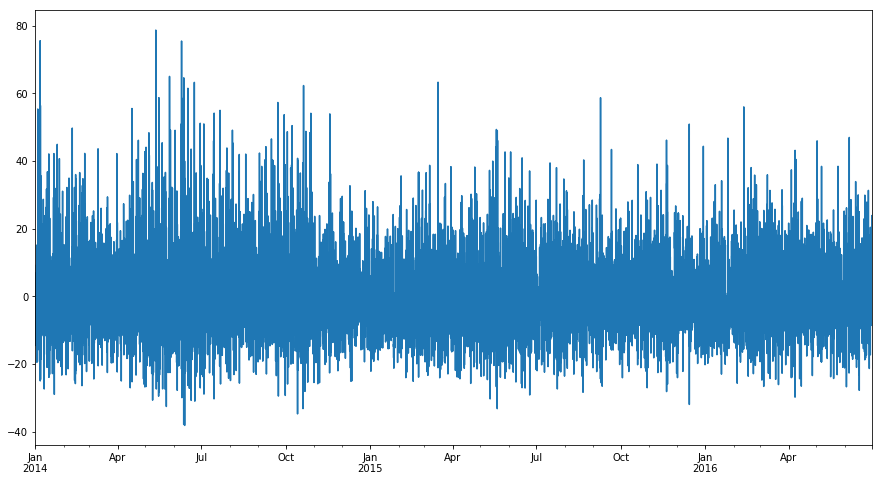

In [48]:
res.plot()

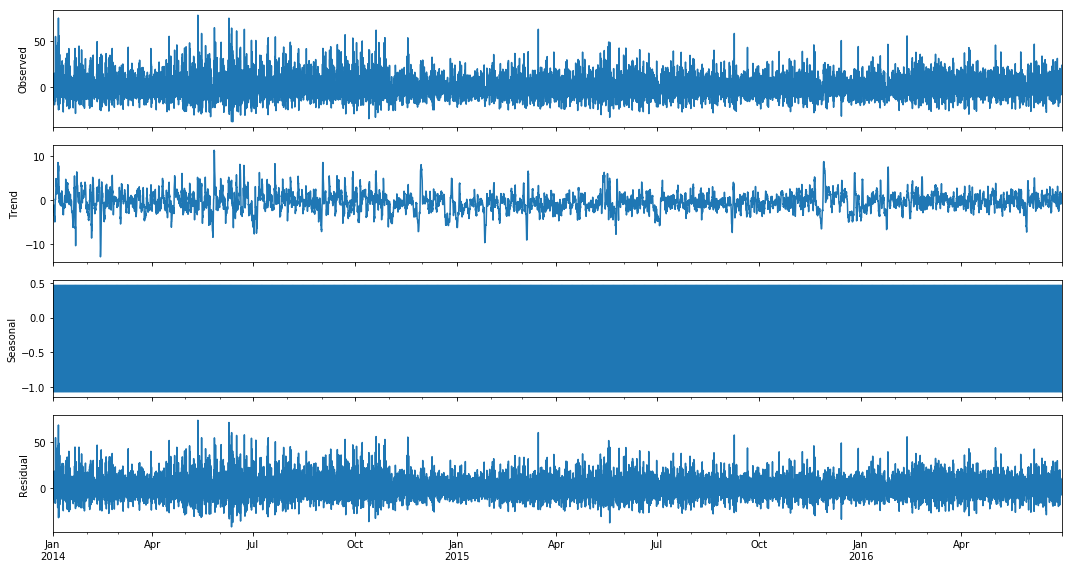

In [49]:
s = sm.tsa.seasonal_decompose(res);
s.plot();

In [76]:
df4.head()

,y,weekSin1,weekSin2,month,hour_19,hour_9,hour_8,year,hour_5,hour_4,...,y3,y4,y5,y6,y1_reg,y2_reg,y3_reg,y4_reg,y5_reg,y6_reg
2014-01-01 00:00:00,10,0.000000,0.000000,1,0,0,0,2014,0,0,...,2.0,1.0,0.0,1.0,0.0,32.042194,15.948785,0.000000,0.000000,0.000000
2014-01-01 01:00:00,2,0.018699,0.037391,1,0,0,0,2014,0,0,...,1.0,0.0,1.0,4.0,0.0,0.000000,0.000000,0.000000,0.000000,80.555915
2014-01-01 02:00:00,1,0.037391,0.074730,1,0,0,0,2014,0,0,...,0.0,1.0,4.0,28.0,0.0,0.000000,0.000000,0.000000,74.817554,107.874459
2014-01-01 03:00:00,2,0.056070,0.111964,1,0,0,0,2014,0,0,...,1.0,4.0,28.0,46.0,0.0,0.000000,0.000000,77.900365,108.835846,141.780908
2014-01-01 04:00:00,1,0.074730,0.149042,1,0,0,0,2014,0,1,...,4.0,28.0,46.0,217.0,0.0,0.000000,75.024184,108.691425,140.323082,210.562388


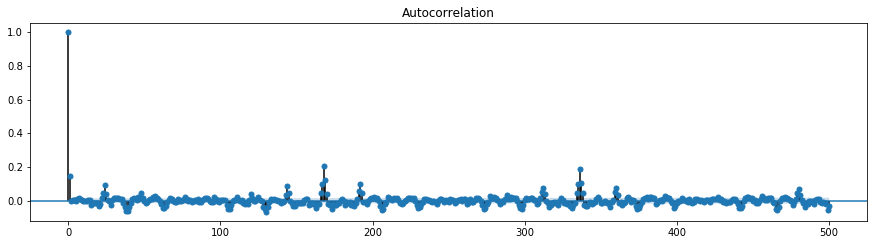

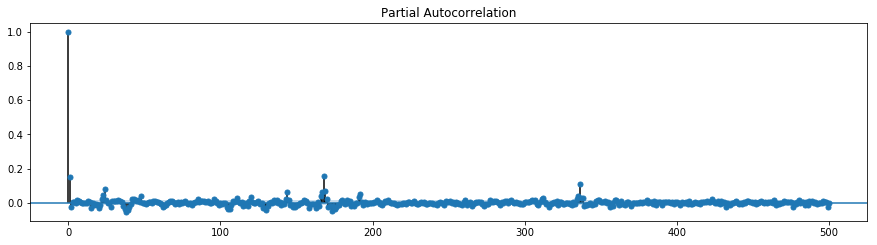

In [50]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(res.values.squeeze(), lags=500, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(res.values.squeeze(), lags=500, ax=ax)
pylab.show()

In [ ]:
sarimaxParams = np.load('sarimaxParams.npy').item()

In [ ]:
# получаем параметры SARIMAX модели
params = sarimaxParams.get(regId)

In [74]:
ps = range(1, 5)
d  = 1
qs = range(1, 5)

Ps = range(1, 5)
D  = 1
Qs = range(1, 5)


pList = list(product(ps, qs, Ps, Qs))

[1, 2, 3, 4] 1 [1, 2, 3, 4] [1, 2, 3, 4] 1 [1, 2, 3, 4]


In [75]:
results = []
best_aic = float("inf")

for params in pList:
    print params
    try:
        mSARIMA=sm.tsa.statespace.SARIMAX(ts.loc[startTrain:endValidation,'y'], order=[params[0], 0, params[1]],
                                  seasonal_order=(params[2], 0, params[3], 24),
                                  exog = ts.loc[startTrain:endValidation,'regressor1']).fit(disp=1)
    except Exception as inst:
        print inst           # __str__ allows args to be printed directly
        continue 
    else:     
        aic = mSARIMA.aic
        print('AIC',aic) 
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = mSARIMA
            best_aic = aic
            best_param = params
        results.append([params, mSARIMA.aic])

(1, 1, 1, 1)
'the label [regressor1] is not in the [columns]'
(1, 1, 1, 2)
'the label [regressor1] is not in the [columns]'
(1, 1, 1, 3)
'the label [regressor1] is not in the [columns]'
(1, 1, 1, 4)
'the label [regressor1] is not in the [columns]'
(1, 1, 2, 1)
'the label [regressor1] is not in the [columns]'
(1, 1, 2, 2)
'the label [regressor1] is not in the [columns]'
(1, 1, 2, 3)
'the label [regressor1] is not in the [columns]'
(1, 1, 2, 4)
'the label [regressor1] is not in the [columns]'
(1, 1, 3, 1)
'the label [regressor1] is not in the [columns]'
(1, 1, 3, 2)
'the label [regressor1] is not in the [columns]'
(1, 1, 3, 3)
'the label [regressor1] is not in the [columns]'
(1, 1, 3, 4)
'the label [regressor1] is not in the [columns]'
(1, 1, 4, 1)
'the label [regressor1] is not in the [columns]'
(1, 1, 4, 2)
'the label [regressor1] is not in the [columns]'
(1, 1, 4, 3)
'the label [regressor1] is not in the [columns]'
(1, 1, 4, 4)
'the label [regressor1] is not in the [columns]'
(1, 2, 1

In [ ]:
-

Так мы получили регрессионные предсказания для всех регионов на весь доступный диапазон дат.

Выберите вашу любимую регрессионную модель и настройте её на каждом из шести наборов данных, подбирая гиперпараметры на мае 2016. Желательно, чтобы модель:
<ul>
<li>Допускала попарные взаимодействия между признаками
<li>Была устойчивой к избыточному количеству признаков (например, использовала регуляризаторы)
</ul>

Попробуем обучить Ridge классификатор с L2 регуляризацией.

In [ ]:
bestModels = dict()
for target in targetList:
    print target
    dropCols = [x for x in targetList if x != target ]
    dropCols.append('y')
    dropCols.append('index')
    tmpTrain = trainSet.drop(dropCols,axis = 1)
    tmpTrain.rename(columns={target:'y'},inplace=True)
    
    tmpValidation = validationSet.drop(dropCols,axis = 1)
    tmpValidation.rename(columns={target:'y'},inplace=True)
    
    minErr = np.inf
    bestAlpha = 0
    
    
    for a in paramsAlpha:
        regressor = linear_model.Ridge(alpha= a)
        regressor.fit(tmpTrain.drop('y',axis = 1),tmpTrain.loc[:,'y'])
        prediction = regressor.predict(tmpValidation.drop('y',axis = 1))
        err = np.abs(prediction - tmpValidation.loc[:,'y'])
        err = err.mean()
        print a, err
        if err <minErr:
            minErr = err
            bestAlpha = a
            bestModel = regressor
    
    bestModels.update({target:bestModel})
            
    print 'Smallest error {:2.3f} at a = {:2.3f}'.format(err,a)     

In [ ]:
# now there are three regressors. WE have to use them.
#np.save('bestModels.npy',bestModels)
#bestModels = np.load('bestModels.npy').item()

In [ ]:
bestModels = dict()


for target in targetList:
    print target
    dropCols = [x for x in targetList if x != target ]
    dropCols.append('y')
    dropCols.append('index')
    tmpTrain = trainSet.drop(dropCols,axis = 1)
    tmpTrain.rename(columns={target:'y'},inplace=True)
    
    tmpValidation = validationSet.drop(dropCols,axis = 1)
    tmpValidation.rename(columns={target:'y'},inplace=True)
    
    regressor = DTR()
    regressor.fit(tmpTrain.drop('y',axis = 1),tmpTrain.loc[:,'y'])
    prediction = regressor.predict(tmpValidation.drop('y',axis = 1))
    err = np.abs(prediction - tmpValidation.loc[:,'y'])
    err = err.mean()

    bestModels.update({target:regressor})
            
    print 'Smallest error {:2.3f} at a = {:2.3f}'.format(err,a)     

In [ ]:
dropCols = ['index','y','y1','y2','y3','y4','y5','y6']
prediction = getTrips(testSet.drop(dropCols, axis = 1))

predictionDf = pd.DataFrame(prediction.T,columns=['y1','y2','y3','y4','y5','y6'])
predictionDf.set_index(testSet.index,inplace=True)
predictionDf = predictionDf.merge(regDf,left_index=True,right_index=True,how='left')
predictionDf = predictionDf.round()

diff  = np.abs(predictionDf.y1-testSet.y1)+np.abs(predictionDf.y2-testSet.y2)+np.abs(predictionDf.y3-testSet.y3)+np.abs(predictionDf.y4-testSet.y4)+np.abs(predictionDf.y5-testSet.y5)+np.abs(predictionDf.y6-testSet.y6)
print 'Error is', diff.mean()/6

In [ ]:
# теперь надо сохранить это в файл
fName = 'res_week5-4.csv'
saveResults(predictionDf,fName)

In [ ]:
predictionDf

In [ ]:
testSet.query("region == '2168'")

deal with the dictionary of parameters

In [ ]:
np.save('sarimaxParams', sarimaxParams)  

In [78]:
colName = list()

In [81]:
colName.append('week1')

In [82]:
colName

['week1', 'week1']